In [1]:
import requests
import pandas as pd
import numpy as np
import jsonlines
import time
from tqdm import tqdm
from collections import defaultdict

# Load information about ISO 2 digit country codes

In [2]:
df_iso = pd.read_csv("./data/iso_countries.csv").set_index('alpha-2')
df_iso

,name,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
alpha-2,,,,,,,,,,
AF,Afghanistan,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
AX,Åland Islands,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
AL,Albania,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
DZ,Algeria,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
AS,American Samoa,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...
WF,Wallis and Futuna,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,NaN,9.0,61.0,NaN
EH,Western Sahara,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,NaN,2.0,15.0,NaN
YE,Yemen,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NaN,142.0,145.0,NaN


# Load Publication Data from jsonlines file

In [3]:
publications = []
with jsonlines.open("./data/openalex_publications.jsonl") as f_in:
    for pub in f_in:
        publications.append(pub)


Create a dataframe with basic publication metadata so we can join with geoparsing results

In [4]:
pub_records = []
for doc_id, pub in enumerate(publications):
    pub_records.append({
        'doc_id': doc_id,
        'title': pub['display_name'],
        'publication_year': pub['publication_year'],
        'cited_by_count': pub['cited_by_count'],        
    })

In [5]:
df_pubs = pd.DataFrame(pub_records)

# Load Geoparsing Results

In [6]:
df_geoparsing = pd.read_csv("./data/geoparsing.csv")

Create a dataframe mapping doc_ids to countries that are mentioned

In [7]:
df_pub_geo = pd.DataFrame(df_pubs).merge(
    df_geoparsing[['doc_id', 'in_country']].dropna().drop_duplicates(),
    left_on='doc_id',
    right_on='doc_id',
)

Calulcate the number of publications that mention each country

In [8]:
df_country_mentions = pd.DataFrame(df_pub_geo.groupby(['in_country']).size(), columns=['pub_count']).merge(
    df_iso[['name', 'region']],
    left_index=True,
    right_index=True,
    how='left'
).sort_values('pub_count', ascending=False)

In [9]:
df_country_mentions.head(20)

,pub_count,name,region
in_country,,,
ID,619,Indonesia,Asia
IN,453,India,Asia
CN,426,China,Asia
BR,193,Brazil,Americas
PK,177,Pakistan,Asia
US,167,United States of America,Americas
TH,140,Thailand,Asia
AO,117,Angola,Africa
MY,98,Malaysia,Asia


# Compare focus of research publications to incidence rates in countries
For this analysis, I used data from [https://doi.org/10.1016/j.eclinm.2020.100712](https://doi.org/10.1016/j.eclinm.2020.100712)

In [10]:
# source https://doi.org/10.1016/j.eclinm.2020.100712
df_dengue = pd.read_csv("./data/Dengue_by_country.csv")[['ISO', 'val']].set_index('ISO')
df_country_incidence = df_country_mentions.merge(df_dengue, left_index=True, right_index=True, how='left').head(20)

In [11]:
df_country_incidence

,pub_count,name,region,val
in_country,,,,
ID,619,Indonesia,Asia,4117.117945
IN,453,India,Asia,4072.924813
CN,426,China,Asia,183.785933
BR,193,Brazil,Americas,2216.493705
PK,177,Pakistan,Asia,1356.955793
US,167,United States of America,Americas,7.301560
TH,140,Thailand,Asia,2206.438514
AO,117,Angola,Africa,440.687915
MY,98,Malaysia,Asia,3667.890332


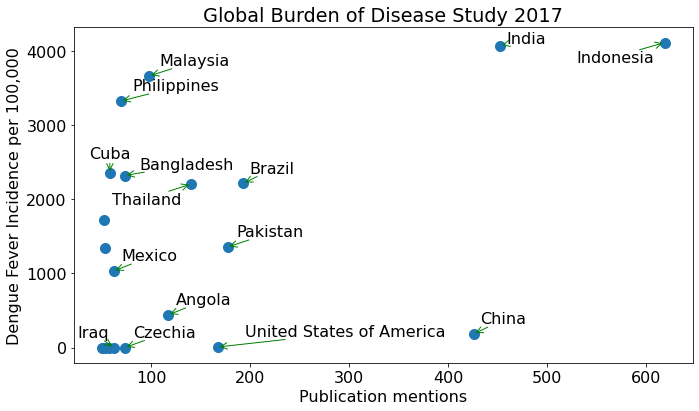

In [34]:
# The adjustText library is very useful for labelling scatter plots!
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_country_incidence['pub_count'], df_country_incidence['val'], s=100)
labels = []
for i, row in df_country_incidence.head(15).iterrows():
    labels.append(ax.text(
        row['pub_count'],
        row['val'],
        row['name']
    ))
adjust_text(labels, arrowprops=dict(arrowstyle='->', color='green'), force_points=(5,5))
ax.set_xlabel("Publication mentions")
ax.set_ylabel("Dengue Fever Incidence per 100,000")
ax.set_title("Global Burden of Disease Study 2017")
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig("./analysis/publication_country_mentions.png", dpi=150, bbox_inches='tight')
plt.show()

# Compare Geographic mentions to topics

In [13]:
df_topics = pd.read_csv("./data/publication_topics.csv").set_index('doc_id')

In [14]:
df_topic_labels = df_topics[['topic', 'topic_label']].drop_duplicates().set_index('topic').sort_index()

In [15]:
df_topic_countries = df_topics.merge(df_pub_geo, left_index=True, right_index=True, how='left').dropna()

Filter to countries in the top 20 list

In [16]:
df_topic_countries[df_topic_countries['in_country'].isin(df_country_incidence.index)]

,cited_by_count_x,topic,topic_weight,topic_label,hex_colour,topic x,topic y,doc_id,title,publication_year,cited_by_count_y,in_country
doc_id,,,,,,,,,,,,
1,104,0,0.023306,0: [n=703] outbreak|surveillance|epidemic|repo...,#e6194B,5.709376,7.739736,1.0,"Autochthonous Dengue Fever, Tokyo, Japan, 2014",2015.0,104.0,JP
3,110,10,0.090262,10: [n=289] model|models|transmission|dynamics...,#469990,0.908253,11.685554,5.0,"Dengue Fever: Causes, Complications, and Vacci...",2016.0,83.0,MX
4,58,19,0.031798,19: [n=78] clinical|profile|laboratory|manifes...,#a9a9a9,5.463806,7.692357,5.0,"Dengue Fever: Causes, Complications, and Vacci...",2016.0,83.0,BR
5,83,9,0.067433,9: [n=386] denv|vaccine|serotypes|cells|viral|...,#fabed4,6.620436,8.559033,5.0,"Dengue Fever: Causes, Complications, and Vacci...",2016.0,83.0,PH
6,56,13,0.037690,13: [n=329] diseases|infectious|covid_19|malar...,#fffac8,4.526115,8.792115,8.0,Dengue fever in China,2015.0,55.0,CN
...,...,...,...,...,...,...,...,...,...,...,...,...
4443,1,13,0.070768,13: [n=329] diseases|infectious|covid_19|malar...,#fffac8,2.754325,9.437291,12681.0,Independent Evaluation of Two Prototype Immuno...,2022.0,0.0,ID
4444,2,13,0.072380,13: [n=329] diseases|infectious|covid_19|malar...,#fffac8,2.668365,8.867453,12684.0,"The knowledge, attitude and practice of commun...",2022.0,0.0,ID
4446,1,9,0.054824,9: [n=386] denv|vaccine|serotypes|cells|viral|...,#fabed4,5.743280,8.227322,12687.0,Protocol: MHC class I and dengue hemorrhagic f...,2022.0,0.0,ID


# Heatmap Topic - Country Mentions

In [17]:
df_heatmap = pd.DataFrame(df_topic_countries[df_topic_countries['in_country'].isin(df_country_incidence.index)].groupby(['topic', 'in_country']).size(), columns=['pub_count']).unstack('in_country').fillna(0)

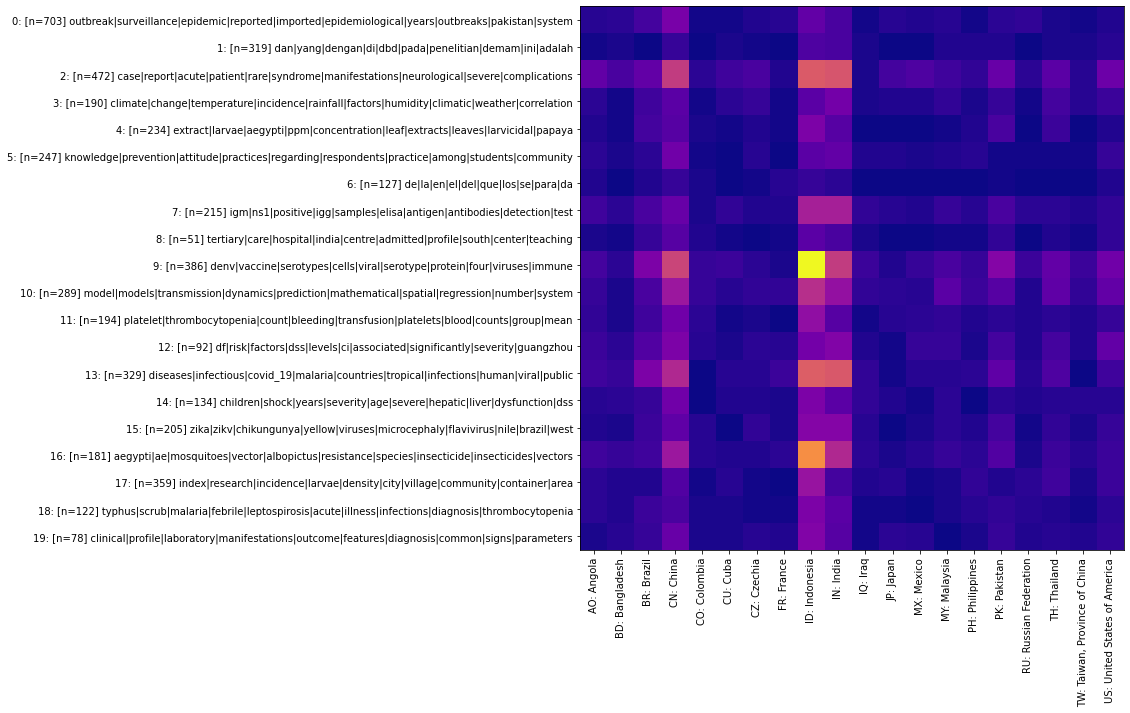

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(df_heatmap, cmap="plasma")
ax.set_yticks(np.arange(len(df_topic_labels)))
ax.set_yticklabels(df_topic_labels['topic_label'])
ax.set_xticks(np.arange(len(df_country_incidence)))
ax.set_xticklabels(["{}: {}".format(cc, df_iso.loc[cc]['name']) for cc in df_heatmap.columns.get_level_values(1)], rotation=90)
fig.patch.set_facecolor('white')
plt.savefig("./analysis/publication_topic_country_mentions.png", dpi=150, bbox_inches='tight')
plt.show()

China is the most mentioned country for topic 3 - climate change

India and Indoenesia are the most mentioned countries for topic 9 - vaccines

# Does research in certain locations come from author in those countries?

Now calculate the authorship for articles mentioning ID, IN, CN, BR, PK

In [20]:
study_countries = ['ID', 'IN', 'CN', 'BR', 'PK']
country_mentions = []

for country_code in df_country_incidence.head(5).index:
    author_country_count = defaultdict(int)
    for doc_id in df_topic_countries.query("in_country=='{}'".format(country_code)).index:
        pub = publications[doc_id]
        for authorship in pub['authorships']:
            for institution in authorship['institutions']:
                aff_country_code = institution['country_code']
                if aff_country_code:
                    author_country_count[aff_country_code] += 1

    country_mentions.append(
        pd.DataFrame.from_dict(
            author_country_count, orient='index', columns=['{}_mention_count'.format(country_code)]
        )
    )
df_mention_authors = pd.concat(country_mentions, axis=1).fillna(0)    

In [21]:
df_plot = df_mention_authors.loc[study_countries]
df_plot

,ID_mention_count,IN_mention_count,CN_mention_count,BR_mention_count,PK_mention_count
ID,112.0,62.0,76.0,14.0,26.0
IN,270.0,213.0,167.0,108.0,57.0
CN,100.0,22.0,130.0,47.0,86.0
BR,230.0,181.0,157.0,52.0,94.0
PK,69.0,44.0,37.0,31.0,13.0


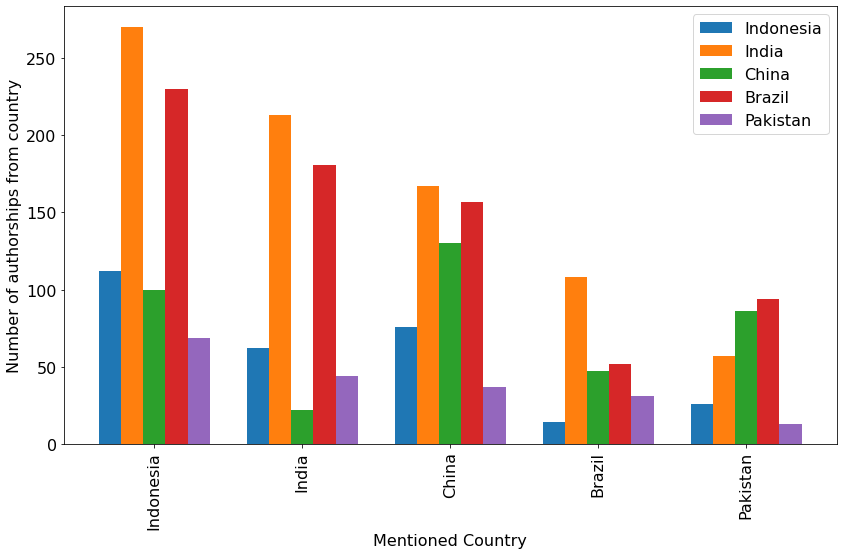

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
mpl.rcParams['font.size'] = 16

x = np.arange(len(study_countries))
#ax.plot(df_plot.index, df_plot['%_global_author_count'], ls=':', label='global')
for i, country in enumerate(study_countries):
    ax.bar(
        x+(0.15*i), 
        df_plot.loc[country].values,
        #df_plot['%_{}_mention_count'.format(country)], 
        #df_plot['{}_mention_count'.format(country)], 
        width=0.15,
        label=df_iso.loc[country]['name']
    )

ax.set_xticks(x+0.3)
ax.set_xticklabels([df_iso.loc[cc]['name'] for cc in study_countries], rotation=90)
ax.set_xlabel("Mentioned Country")
ax.set_ylabel("Number of authorships from country")
plt.legend() #(bbox_to_anchor=(1.01, 1.01))
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig("./analysis/publication_country_mentions_authors.png", dpi=150, bbox_inches='tight')
plt.show()

More authors from India and Brazil mention Indonesia than there own country

China & Brazil more focussed on Pakistan than other countries